# Cellular automatons
A cellular automaton (CA) is a model of a simple world governed by even simpler rules. "Cellular" means the world is divided into discrete chunks. "Automaton" in general means computation, but in this context, the computations are very simple, and are more easily understood as rules.

We're going to focus on one dimensional (1D) CAs. Here is a 1D CA with 11 cells. Each cell can be in one of two states: on or off. This CA starts with the center cell on and all others off.

In [1]:
import numpy as np
world = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
print(world)

[0 0 0 0 0 1 0 0 0 0 0]


This is the state of the initial timestep for this CA, but interesting things happen in future timesteps depending on what rule we use to determine which cells turn on and which ones turn off. Behavior of a given cell depends on its state and the state of its two neighbors.

prev | 111 | 110 | 101 | 100 | 011 | 010 | 001 | 000 |
-----|-----|-----|-----|-----|-----|-----|-----|-----|
next |  0  |  0  |  1  |  1  |  0  |  0  |  1  |  0  |

The "next" row (the rule) is arbitrarily decided. You can come up with whatever rule you want.

**How many different rules are there?**

Steven Wolfram explored all possible rules and identified different classes of behavior. Wolfram saw that each rule can be represented in binary. So for instance the rule in the table about is called Rule 50 because 50 in binary is 00110010. Converting from a rule to a table like the one in the table above can be done as follows:

In [2]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]  # ???
    return table

make_table(50)

array([0, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

prev | 000 | 001 | 010 | 011 | 100 | 101 | 110 | 111 |
-----|-----|-----|-----|-----|-----|-----|-----|-----|
next |  0  |  1  |  0  |  0  |  0  |  0  |  1  |  0  |

Now we can use this table to look up the value at the next timestep for a cell with a given state of self and neighbors.

In [3]:
table = make_table(50)
cells_to_look_up = [0,  # No one is on
                    1,  # Cell to right is on
                    7]  # Everyone is on
table[cells_to_look_up]

array([0, 1, 0], dtype=uint8)

**Why does `make_table()` reverse the unpacked bits when making the table?**  
Hint: The two html tables show the same rule.

Applying Rule 50 to our initial world yields the following world at the next timestep.

In [4]:
world = np.array([world, [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])
print(world)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]]


A different way to visualize 1D CAs over time is to use `plt.imshow`.

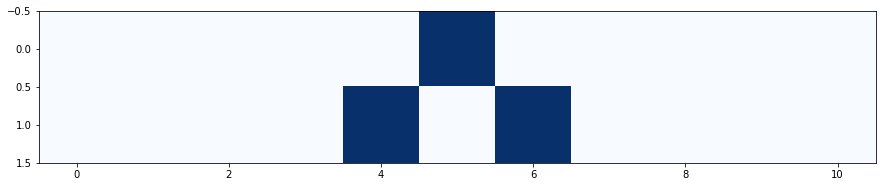

In [33]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

width = 15
height = 10
matplotlib.rcParams['figure.figsize'] = (width, height)

def plot_ca(array):
    cmap = plt.get_cmap('Blues')
    plt.imshow(array, interpolation='none', cmap=cmap)

plot_ca(world)

To run a real CA simulation, the first thing to do is to create a big array of 0s, with columns for every cell, and rows for every timestep you want to compute.

In [34]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.int8)
print(array)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


Next we need to decide a starting condition. Let's turn the center cell on.

In [35]:
array[0, cols//2] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


Now we can iterate through the rows, applying the correct rule at each step. To apply the rule, we need to convert each value in the row into a value between 0 and 7 corresponding to the column in the rule table that denotes the correct state of the cell and its neighbors. Then we look up the rule to create the next row.

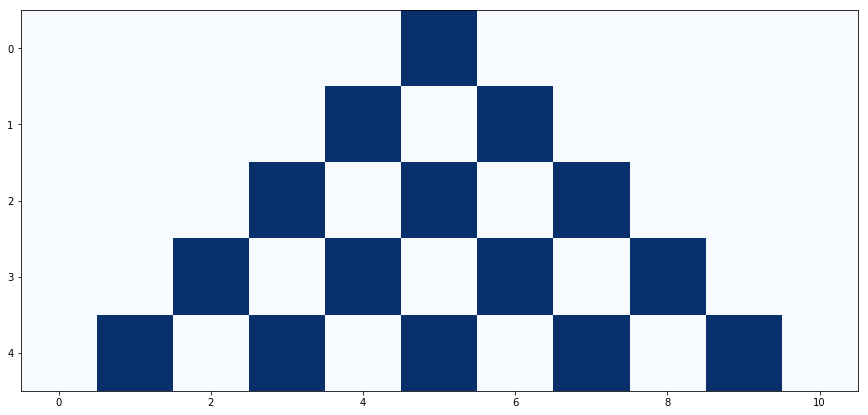

In [36]:
def step(array, i):
    """Executes one time step by computing the next row of the array."""
    window = [4,  # 100
              2,  # 010
              1]  # 001
    corr = np.correlate(array[i-1], [4, 2, 1], mode='same')
    array[i] = table[corr]

for i in range(1, rows):
    step(array, i)

plot_ca(array)

# Putting everything together

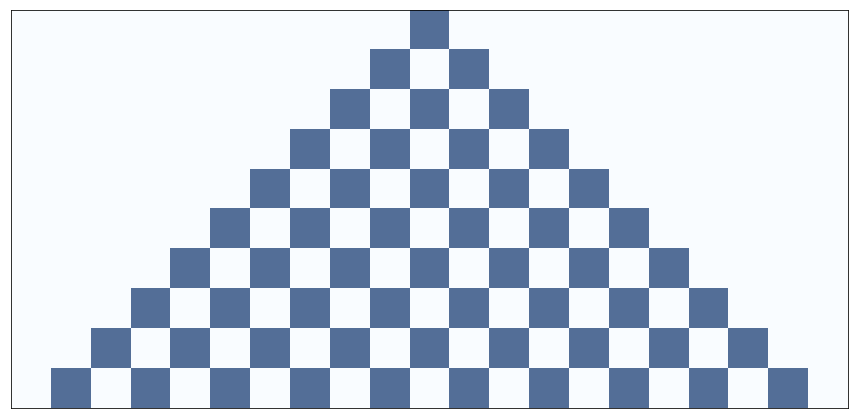

In [37]:
from thinkcomplexity.cellular_automatons import Cell1D, Cell1DViewer

rule = 50
n = 10
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

In [38]:
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.random(self.m).round()
        self.next += 1

    def start_string(self, init):
        """Start with values from a string of 1s and 0s."""
        self.array[0] = np.array([int(x) for x in init])
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        corr = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[corr]
        self.next += 1

    def get_array(self, start=0, end=None):
        """Gets a slice of columns from the CA. Useful for plotting.

        Avoids copying if possible.

        start: index of first column
        end: index of the last column plus one
        """
        if start==0 and end==None:
            return self.array
        else:
            return self.array[:, start:end]


class Cell1DViewer:
    """Draws a CA object using matplotlib."""

    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.7, interpolation='nearest')

    def __init__(self, ca):
        self.ca = ca

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.ca.get_array(start, end)
        n, m = a.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        plt.imshow(a, cmap=self.cmap, **self.options)

## Rule 18

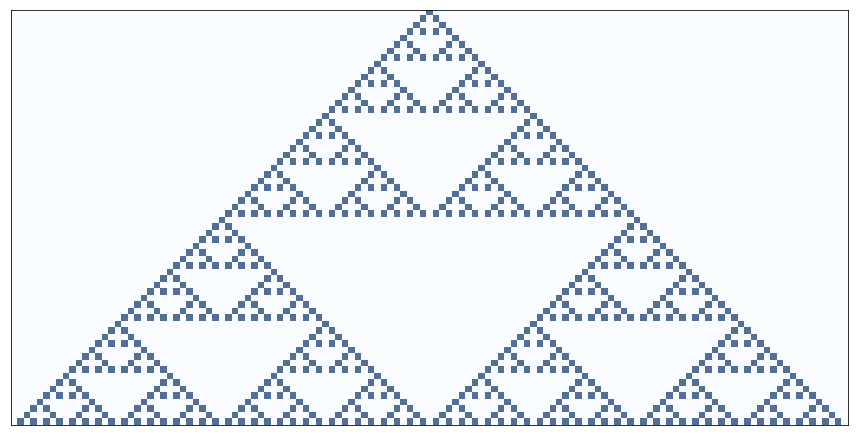

In [39]:
rule = 18
n = 64
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

## Rule 30

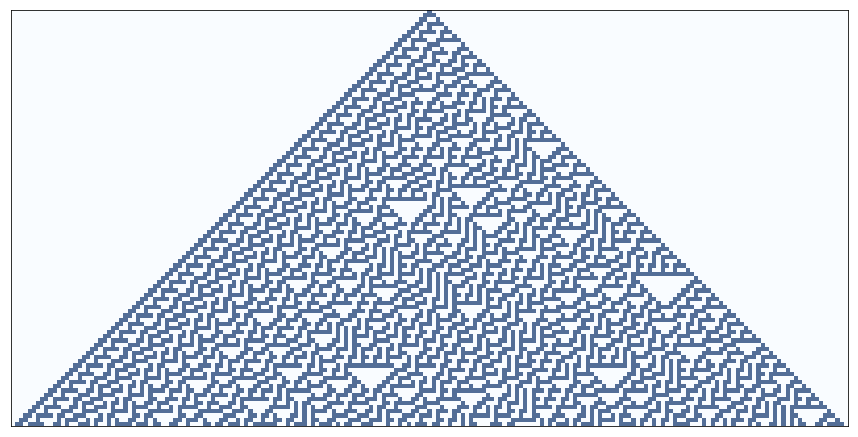

In [40]:
rule = 30
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

## Rule 110
[Wikipedia: Rule 110](https://en.wikipedia.org/wiki/Rule_110)

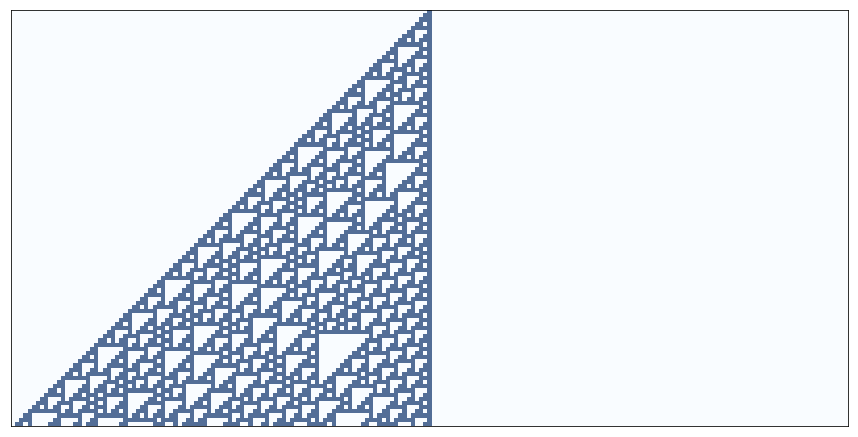

In [41]:
rule = 110
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

## Other rules
[Wikipedia: Elementary cellular automaton](https://en.wikipedia.org/wiki/Elementary_cellular_automaton)

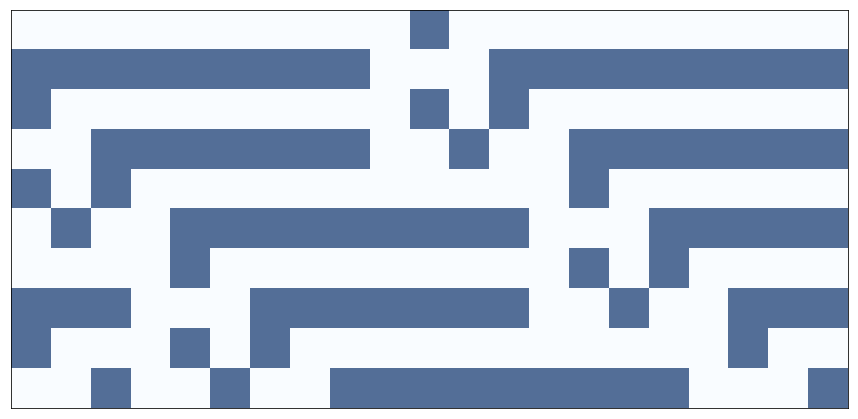

In [42]:
rule = 41
n = 10
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

In [43]:
make_table(41)

array([1, 0, 0, 1, 0, 1, 0, 0], dtype=uint8)

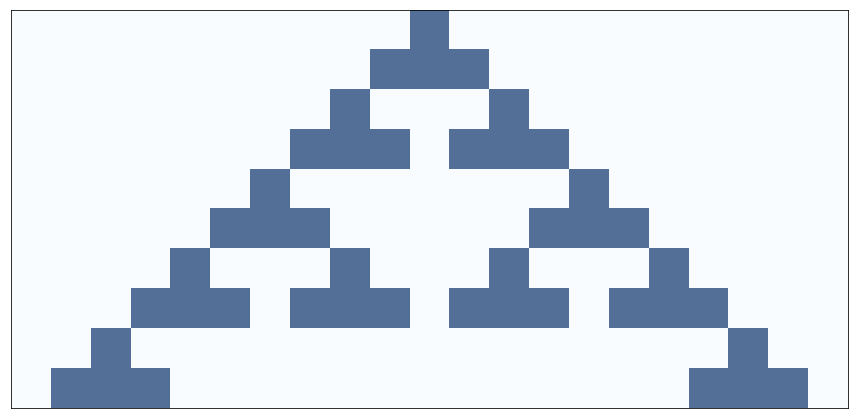

In [44]:
rule = 22
n = 10
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

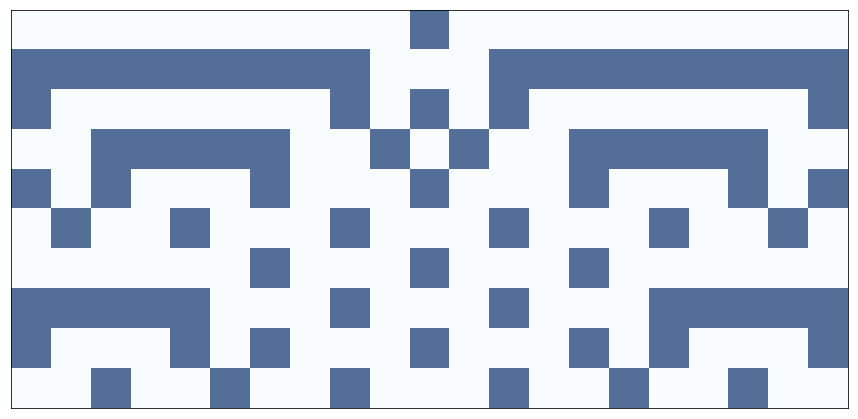

In [45]:
rule = 105
n = 10
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()